In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder

import wandb_utils
from wandb_utils import log_model_to_wandb

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# --- STEP 1: Load Data ---
X_raw = pd.read_csv("../data/raw/Training_Set_Values.csv")
y_raw = pd.read_csv("../data/raw/Training_Set_Labels.csv")

# Merge on 'id' if needed (ensure labels are aligned)
df = X_raw.merge(y_raw, on="id")
print("df:",df.shape)

df: (59400, 41)


In [3]:
X = df.drop(['status_group','recorded_by'], axis=1) #'id',
y = df['status_group']
df.shape

(59400, 41)

In [4]:
# Simple encoding
X = X.fillna('missing')

# Convert all object and bool columns to strings before encoding
for col in X.select_dtypes(include=['object', 'bool']).columns:
    X[col] = X[col].astype(str)
    X[col] = LabelEncoder().fit_transform(X[col])

# Split data (X and y are already defined)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check class distribution
print(y_train.value_counts(normalize=True))

status_group
functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: proportion, dtype: float64


In [5]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Reusable evaluation function
def evaluate_model(model, X, y, cv=5, scoring="f1_macro"):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=skf, scoring=scoring)
    return scores.mean(), scores.std()

In [15]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Define models
baseline_models = {
    "Dummy (Most Frequent)": DummyClassifier(strategy="most_frequent", random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42)
}

# Evaluate each
results = []
for name, model in baseline_models.items():
    f1, std = evaluate_model(model, X_train, y_train)
    results.append((name, f1, std))


/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_cla

In [16]:
logreg_weighted = LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='multinomial')
dt_weighted = DecisionTreeClassifier(class_weight='balanced', max_depth=5)

# Add to models dict
baseline_models["LogReg (Balanced)"] = logreg_weighted
baseline_models["Decision Tree (Balanced)"] = dt_weighted

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def print_eval_metrics(model, X_val, y_val, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"\n{name} Evaluation:")
    print(classification_report(y_val, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred), display_labels=model.classes_).plot(cmap='Blues')


Dummy (Most Frequent) Evaluation:
                         precision    recall  f1-score   support

             functional       0.54      1.00      0.70      6452
functional needs repair       0.00      0.00      0.00       863
         non functional       0.00      0.00      0.00      4565

               accuracy                           0.54     11880
              macro avg       0.18      0.33      0.23     11880
           weighted avg       0.29      0.54      0.38     11880



/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Logistic Regression Evaluation:
                         precision    recall  f1-score   support

             functional       0.58      0.83      0.68      6452
functional needs repair       0.00      0.00      0.00       863
         non functional       0.53      0.31      0.39      4565

               accuracy                           0.57     11880
              macro avg       0.37      0.38      0.36     11880
           weighted avg       0.52      0.57      0.52     11880


Decision Tree Evaluation:
                         precision    recall  f1-score   support

             functional       0.68      0.93      0.79      6452
functional needs repair       0.38      0.07      0.12       863
         non functional       0.83      0.54      0.66      4565

               accuracy                           0.72     11880
              macro avg       0.63      0.51      0.52     11880
           weighted avg       0.72      0.72      0.69     11880



/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogReg (Balanced) Evaluation:
                         precision    recall  f1-score   support

             functional       0.64      0.30      0.40      6452
functional needs repair       0.11      0.53      0.19       863
         non functional       0.49      0.52      0.50      4565

               accuracy                           0.40     11880
              macro avg       0.41      0.45      0.36     11880
           weighted avg       0.54      0.40      0.43     11880


Decision Tree (Balanced) Evaluation:
                         precision    recall  f1-score   support

             functional       0.71      0.62      0.66      6452
functional needs repair       0.18      0.48      0.27       863
         non functional       0.67      0.59      0.63      4565

               accuracy                           0.60     11880
              macro avg       0.52      0.56      0.52     11880
           weighted avg       0.66      0.60      0.62     11880



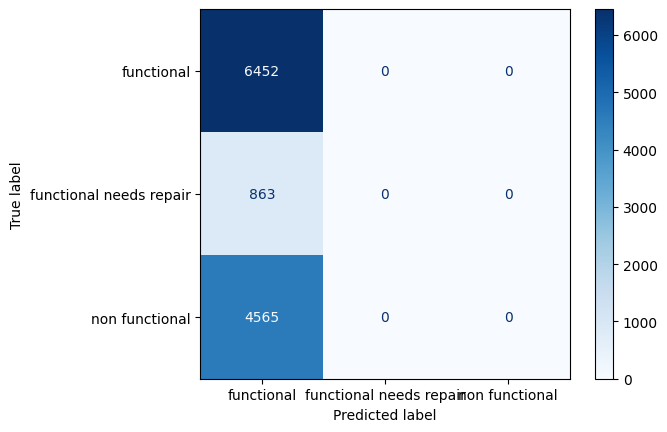

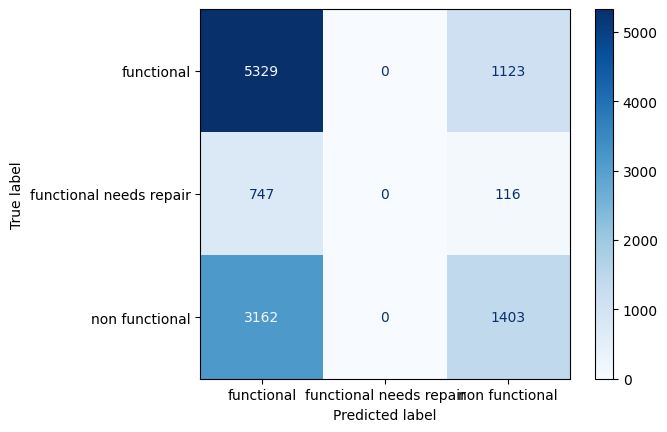

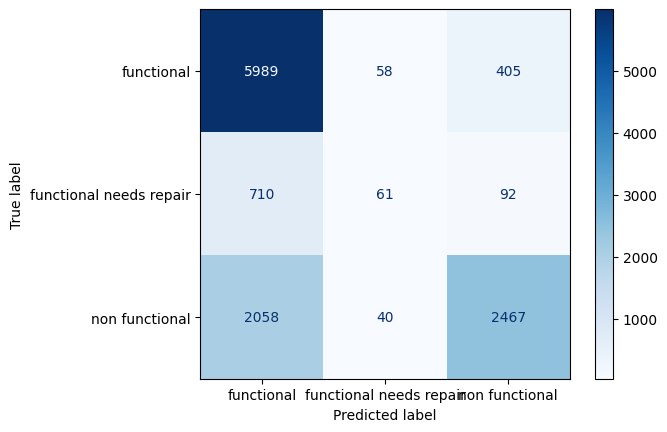

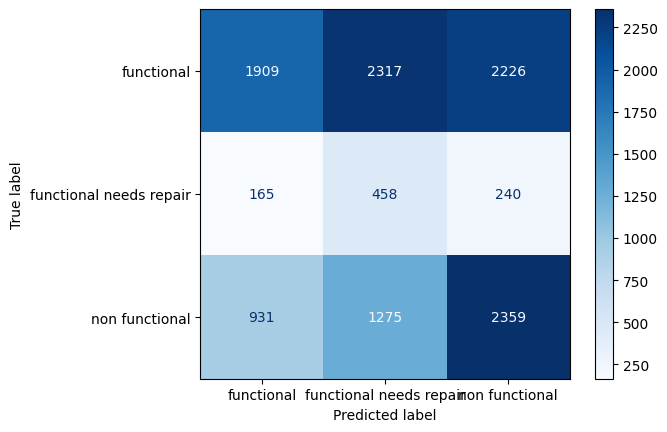

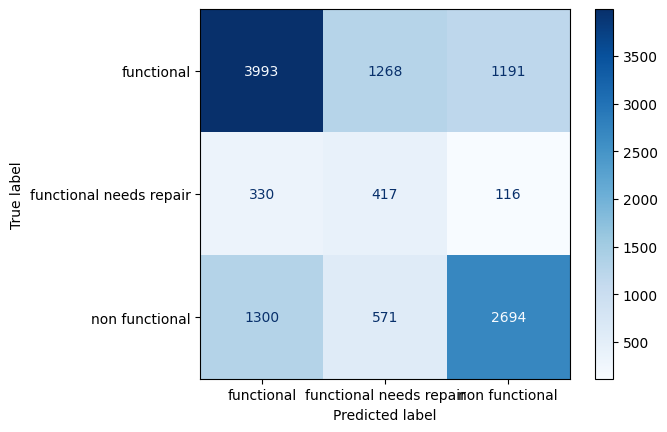

In [18]:
for name, model in baseline_models.items():
    print_eval_metrics(model, X_val, y_val, name)


Dummy (Most Frequent) Evaluation:
                         precision    recall  f1-score   support

             functional       0.54      1.00      0.70      6452
functional needs repair       0.00      0.00      0.00       863
         non functional       0.00      0.00      0.00      4565

               accuracy                           0.54     11880
              macro avg       0.18      0.33      0.23     11880
           weighted avg       0.29      0.54      0.38     11880



/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_f1_macro,▁
val_accuracy,0.5431
val_f1_macro,0.23464


/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: 


Logistic Regression Evaluation:
                         precision    recall  f1-score   support

             functional       0.58      0.83      0.68      6452
functional needs repair       0.00      0.00      0.00       863
         non functional       0.53      0.31      0.39      4565

               accuracy                           0.57     11880
              macro avg       0.37      0.38      0.36     11880
           weighted avg       0.52      0.57      0.52     11880



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_f1_macro,▁
val_accuracy,0.56667
val_f1_macro,0.35621



Decision Tree Evaluation:
                         precision    recall  f1-score   support

             functional       0.68      0.93      0.79      6452
functional needs repair       0.38      0.07      0.12       863
         non functional       0.83      0.54      0.66      4565

               accuracy                           0.72     11880
              macro avg       0.63      0.51      0.52     11880
           weighted avg       0.72      0.72      0.69     11880



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_f1_macro,▁
val_accuracy,0.71692
val_f1_macro,0.52076


/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogReg (Balanced) Evaluation:
                         precision    recall  f1-score   support

             functional       0.64      0.30      0.40      6452
functional needs repair       0.11      0.53      0.19       863
         non functional       0.49      0.52      0.50      4565

               accuracy                           0.40     11880
              macro avg       0.41      0.45      0.36     11880
           weighted avg       0.54      0.40      0.43     11880



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_f1_macro,▁
val_accuracy,0.39781
val_f1_macro,0.36421



Decision Tree (Balanced) Evaluation:
                         precision    recall  f1-score   support

             functional       0.71      0.62      0.66      6452
functional needs repair       0.18      0.48      0.27       863
         non functional       0.67      0.59      0.63      4565

               accuracy                           0.60     11880
              macro avg       0.52      0.56      0.52     11880
           weighted avg       0.66      0.60      0.62     11880



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_f1_macro,▁
val_accuracy,0.59781
val_f1_macro,0.51909


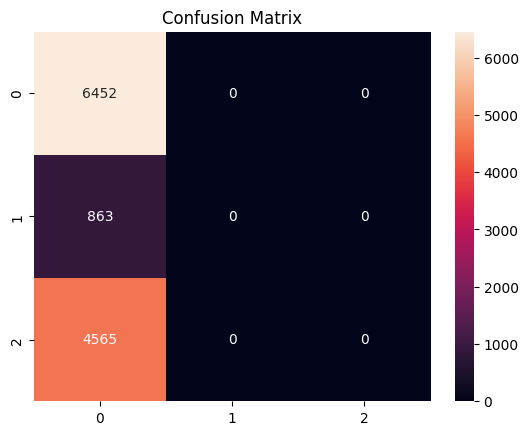

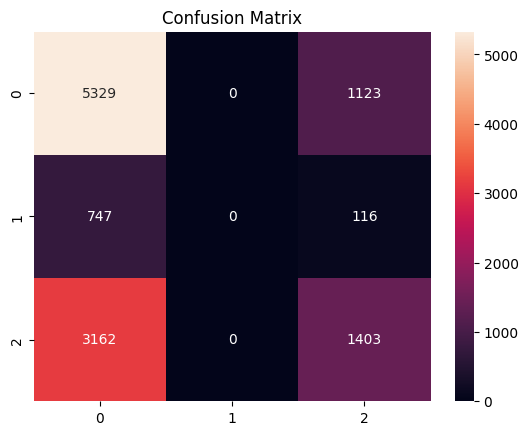

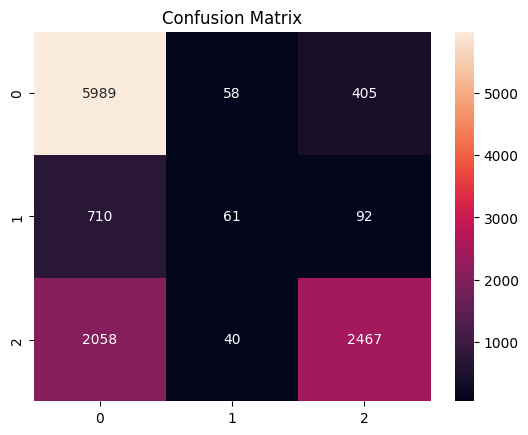

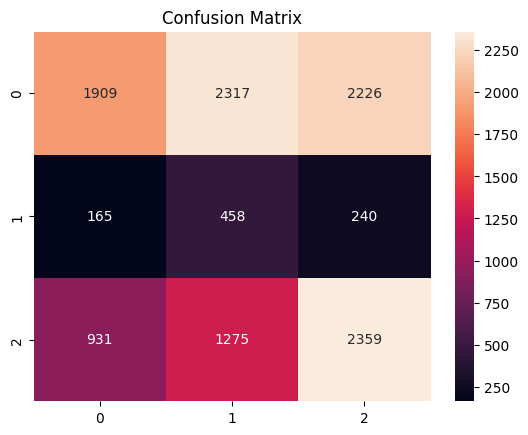

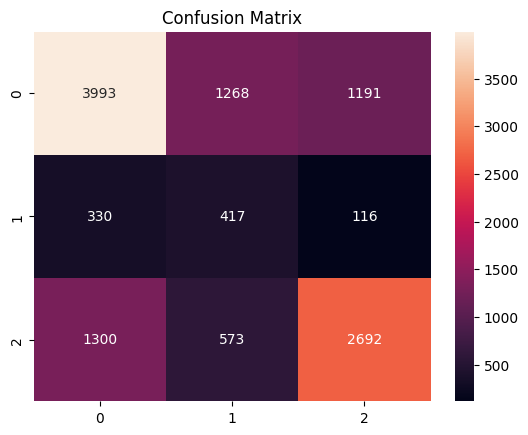

In [19]:
for name, model in baseline_models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_val)
    
    # Print classification report
    print(f"\n{name} Evaluation:")
    print(classification_report(y_val, y_pred))
    
    # Log metrics, config, and confusion matrix to Wandb
    log_model_to_wandb(model, model_name=name, X_val=X_val, y_val=y_val, preds=y_pred, group="baseline_models")


In [20]:
import pandas as pd

benchmark_df = pd.DataFrame(results, columns=["Model", "F1 Score (CV)", "Std Dev"])
benchmark_df.sort_values("F1 Score (CV)", ascending=False)

,Model,F1 Score (CV),Std Dev
2,Decision Tree,0.526664,0.002793
1,Logistic Regression,0.350824,0.004432
0,Dummy (Most Frequent),0.234629,0.000014


                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      6452
functional needs repair       0.58      0.30      0.40       863
         non functional       0.85      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.75      0.66      0.69     11880
           weighted avg       0.81      0.81      0.80     11880



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_f1_macro,▁
val_accuracy,0.81195
val_f1_macro,0.68743


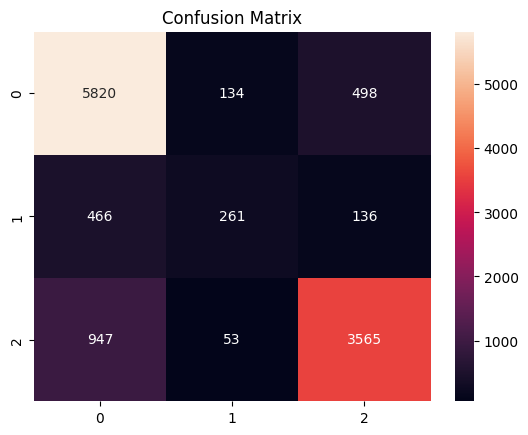

In [22]:
from sklearn.ensemble import RandomForestClassifier
from wandb_utils import log_model_to_wandb


model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# --- Report + W&B Logging ---
print(classification_report(y_val, y_pred))
log_model_to_wandb(model, model_name="RandomForest", X_val=X_val, y_val=y_val, preds=y_pred)

In [16]:
y_train.value_counts(normalize=True)

status_group
2    0.543077
0    0.384238
1    0.072685
Name: proportion, dtype: float64

In [6]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)# x, y

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


In [8]:
search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    scoring='f1_macro',
    cv=3,
    n_iter=20,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  18.4s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  19.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  20.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  20.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  20.7s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  21.6s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n

/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.1min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.1min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 1.0min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 1.1min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 1.1min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  14.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  15.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  13.6s
[CV] END max_depth=None, max_feature

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [12]:
from sklearn.metrics import classification_report

best_model = search.best_estimator_
y_pred = best_model.predict(X_val)

print("Best Params:", search.best_params_)
print("F1 Macro:", search.best_score_)
print(classification_report(y_val, y_pred))


Best Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [28]:
y_resampled.value_counts(normalize=True)

status_group
functional                 0.333333
non functional             0.333333
functional needs repair    0.333333
Name: proportion, dtype: float64

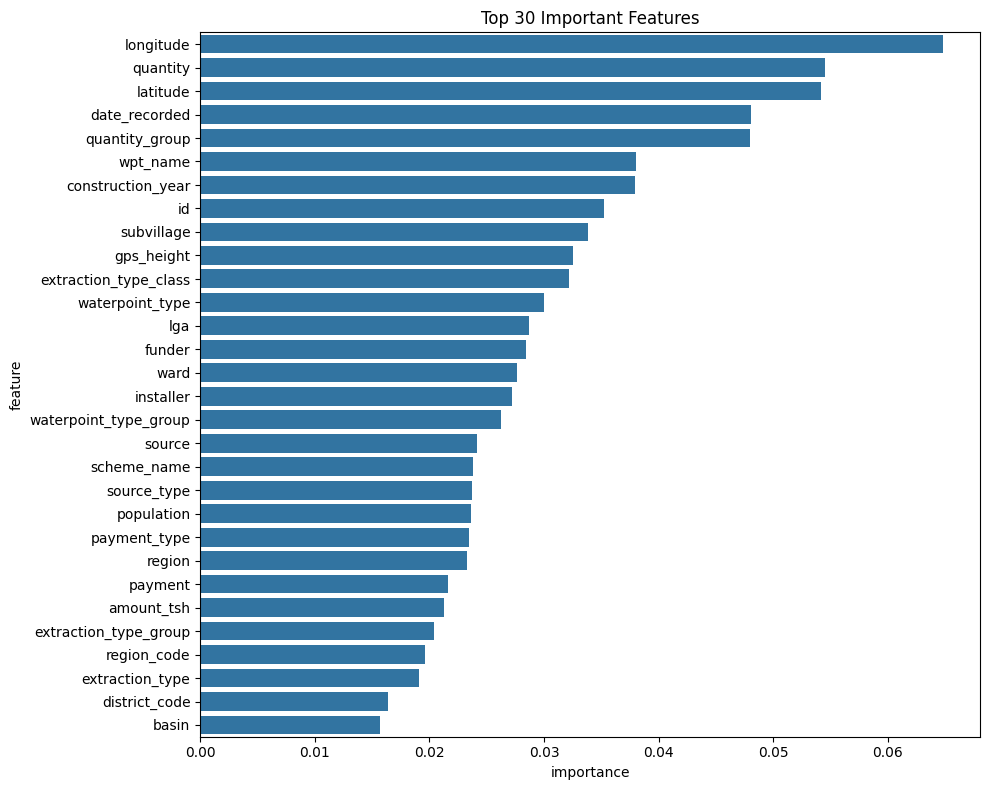

In [29]:
feat_names = X_resampled.columns
feat_imp = search.best_estimator_.feature_importances_

imp_df = pd.DataFrame({
    'feature': feat_names,
    'importance': feat_imp
}).sort_values(by='importance', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.barplot(data=imp_df.head(30), x='importance', y='feature')
plt.title("Top 30 Important Features")
plt.tight_layout()
plt.show()


In [9]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(search.best_estimator_, X_resampled, y_resampled, cv=5, scoring='f1_macro')
print(f"CV F1-macro mean: {scores.mean():.3f}")

CV F1-macro mean: 0.829


CV F1-macro mean: 0.835
CV F1-macro mean: 0.837
CV F1-macro mean: 0.843

In [14]:
# Load and preprocess test set
test_data = pd.read_csv("../data/raw/Test_Set_Values.csv")

# Simple encoding
X_test = test_data.drop(columns=['recorded_by'])
X_test = X_test.fillna('missing')

# Convert all object and bool columns to strings before encoding
for col in X_test.select_dtypes(include=['object', 'bool']).columns:
    X_test[col] = X_test[col].astype(str)
    X_test[col] = LabelEncoder().fit_transform(X_test[col])


In [15]:
# Prepare submission
submission = pd.read_csv("../data/raw/Submission_format.csv")
#submission["status_group"] = test_predictions
y_pred_test = best_model.predict(X_test)
submission["status_group"] = y_pred_test.flatten()
submission.to_csv("submission_RandForest_full.csv", index=False)

## Catboost Model

In [33]:
cat_train_df = df.copy()
print(cat_train_df.shape)
print(cat_train_df.columns)

(59400, 41)
Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')


In [34]:
Xc = cat_train_df.drop(['status_group'], axis=1)
yc = cat_train_df['status_group']

In [35]:
Xc = Xc.fillna('missing')
cat_features = Xc.select_dtypes(include='object').columns.tolist()

In [45]:
categorical_columns = [
    'funder', 'installer','subvillage','lga','ward', 'basin',  
    'extraction_type', 'management','payment_type','water_quality', 
    'source','waterpoint_type', 'funder_installer_pair_grouped','subvillage_funder_installer'
] # 'scheme_management', 'payment', 

In [36]:
from catboost import CatBoostClassifier

# CatBoost can automatically handle missing values and categorical variables
modelc = CatBoostClassifier(
    eval_metric='MultiClass',     # default multi-class logloss (single scalar)
    custom_metric='F1',
    iterations=1000,
    early_stopping_rounds=50,
    learning_rate=0.1,
    depth=6,
    verbose=100,
    random_seed=42
)


## 🧪 4. Train/Test Split and Fit

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    Xc, yc, test_size=0.2, stratify=yc, random_state=42
)

In [ ]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [38]:
modelc.fit(X_train, y_train, cat_features=cat_features) #modelc.fit(X_resampled, y_resampled, cat_features=cat_features)

0:	learn: 1.0181517	total: 261ms	remaining: 4m 20s
100:	learn: 0.5206655	total: 16.6s	remaining: 2m 27s
200:	learn: 0.4974466	total: 34s	remaining: 2m 15s
300:	learn: 0.4840901	total: 52s	remaining: 2m
400:	learn: 0.4729086	total: 1m 10s	remaining: 1m 45s
500:	learn: 0.4651069	total: 1m 30s	remaining: 1m 30s
600:	learn: 0.4560123	total: 1m 50s	remaining: 1m 13s
700:	learn: 0.4483323	total: 2m 9s	remaining: 55.1s
800:	learn: 0.4406352	total: 2m 28s	remaining: 36.9s
900:	learn: 0.4330792	total: 2m 47s	remaining: 18.4s
999:	learn: 0.4263349	total: 3m 7s	remaining: 0us


## 📊 5. Evaluate the Model

In [39]:
from sklearn.metrics import classification_report

y_pred = modelc.predict(X_test)
print(classification_report(y_test, y_pred))


                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6452
functional needs repair       0.61      0.30      0.40       863
         non functional       0.85      0.77      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.75      0.66      0.69     11880
           weighted avg       0.81      0.81      0.80     11880



In [51]:
from sklearn.metrics import f1_score

score = f1_score(y_test, y_pred, average='macro')
print(f"CatBoost F1-macro: {score:.3f}")

CatBoost F1-macro: 0.691


## 🔧 6. Optional: Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500]
}

cb_model = CatBoostClassifier(verbose=0, random_seed=42)
search = GridSearchCV(cb_model, param_grid=params, scoring='f1_macro', cv=3)
search.fit(X_train, y_train, cat_features=cat_features)

best_model = search.best_estimator_


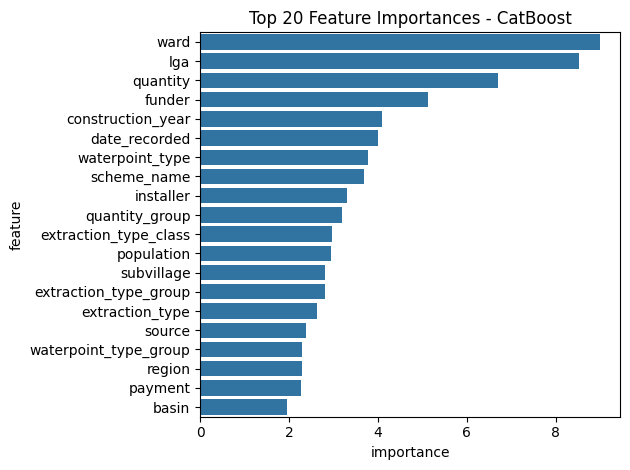

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = modelc.get_feature_importance()
features = X_train.columns

imp_df = pd.DataFrame({'feature': features, 'importance': importances})
imp_df = imp_df.sort_values(by='importance', ascending=False)

sns.barplot(data=imp_df.head(20), x='importance', y='feature')
plt.title("Top 20 Feature Importances - CatBoost")
plt.tight_layout()
plt.show()

In [44]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(modelc, X_resampled, y_resampled, cv=5, scoring='f1_macro')
print(f"CV F1-macro mean: {scores.mean():.3f}")

0:	learn: 1.0465204	total: 30.4ms	remaining: 30.4s
100:	learn: 0.5011913	total: 1.17s	remaining: 10.4s
200:	learn: 0.4283366	total: 2.34s	remaining: 9.29s
300:	learn: 0.3899381	total: 3.44s	remaining: 7.98s
400:	learn: 0.3647435	total: 4.63s	remaining: 6.92s
500:	learn: 0.3442598	total: 5.77s	remaining: 5.74s
600:	learn: 0.3277731	total: 6.88s	remaining: 4.57s
700:	learn: 0.3137910	total: 7.95s	remaining: 3.39s
800:	learn: 0.3010665	total: 9.06s	remaining: 2.25s
900:	learn: 0.2898802	total: 10.2s	remaining: 1.12s
999:	learn: 0.2801643	total: 11.3s	remaining: 0us
0:	learn: 1.0509006	total: 13.1ms	remaining: 13.1s
100:	learn: 0.5710430	total: 1.14s	remaining: 10.1s
200:	learn: 0.5038457	total: 2.31s	remaining: 9.18s
300:	learn: 0.4677332	total: 3.47s	remaining: 8.07s
400:	learn: 0.4427938	total: 4.58s	remaining: 6.84s
500:	learn: 0.4221630	total: 5.66s	remaining: 5.64s
600:	learn: 0.4051103	total: 6.77s	remaining: 4.49s
700:	learn: 0.3907143	total: 7.84s	remaining: 3.34s
800:	learn: 0.37

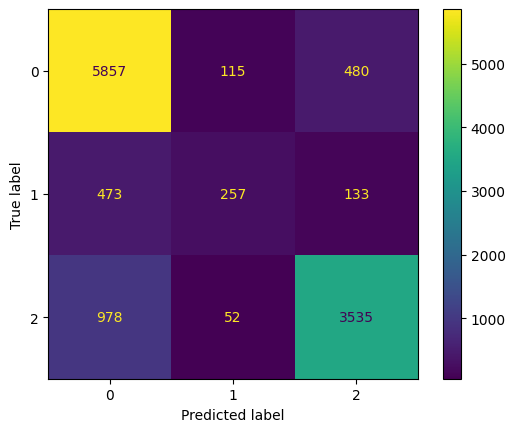

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
print("Best Estimator:", search.best_estimator_)

In [63]:
Xc = cat_train_df.drop(['status_group'], axis=1)
yc = cat_train_df['status_group']

cat_features = Xc.select_dtypes(include='object').columns.tolist()

# --- STEP 1: Split your data (train/test) ---
X_train, X_test, y_train, y_test = train_test_split(
    Xc, yc, test_size=0.2, stratify=yc, random_state=42
)

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report
from catboost import CatBoostClassifier

# --- STEP 2: Handle class imbalance ---
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# --- STEP 3: Define model ---
newmodel = CatBoostClassifier(
    verbose=0,
    random_seed=42,
    eval_metric='MultiClass',
    early_stopping_rounds=None,
    #use_best_model=True,
    class_weights=class_weights
)

# --- STEP 4: Define hyperparameter search space ---
param_dist = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1],
    'l2_leaf_reg': [1, 3],
    'iterations': [100, 200]
}

# --- STEP 5: Set up randomized search with stratified CV ---
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

newsearch = RandomizedSearchCV(
    estimator=newmodel,
    param_distributions=param_dist,
    n_iter=5,
    scoring='f1_macro',
    cv=cv,
    refit=True,
    n_jobs=-1,
    verbose=1
)

Before restarting full tuning, you can time a single fit. That gives you a real estimate of how long a tuning job will take.

In [65]:
import time
start = time.time()
newmodel.fit(X_train, y_train, cat_features=cat_features)
print("Train time:", time.time() - start, "seconds")


Train time: 81.22177219390869 seconds


Fitting 3 folds for each of 5 candidates, totalling 15 fits
F1 Macro: 0.6730444071524323
Classification Report:
                          precision    recall  f1-score   support

             functional       0.85      0.75      0.80      6452
functional needs repair       0.30      0.70      0.42       863
         non functional       0.84      0.77      0.80      4565

               accuracy                           0.75     11880
              macro avg       0.66      0.74      0.67     11880
           weighted avg       0.80      0.75      0.77     11880



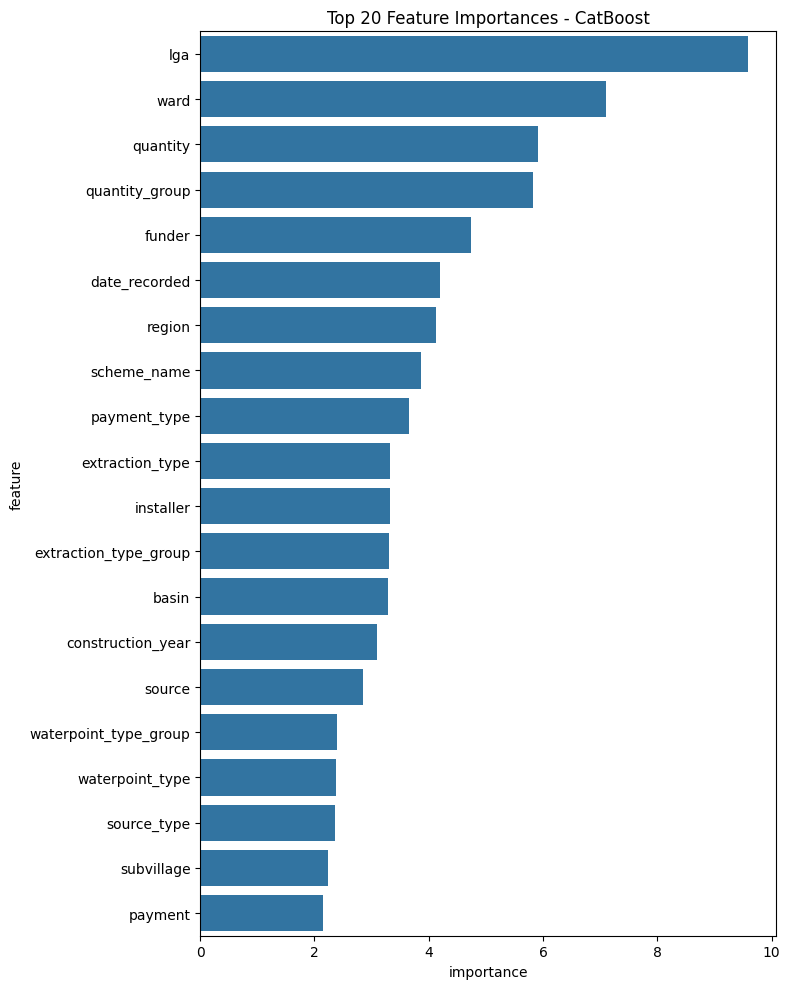

In [50]:
# Identify categorical feature indices
# cat_features = ['region', 'extraction_type', 'installer', ...]
# If using DataFrame: you can use column names instead
newsearch.fit(X_train, y_train, cat_features=cat_features)

# --- STEP 6: Evaluate best model ---
new_best_model = newsearch.best_estimator_

y_pred = new_best_model.predict(X_test)
print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred))

# --- STEP 7: (Optional) Feature importance ---
import matplotlib.pyplot as plt
import seaborn as sns

feat_importance = new_best_model.get_feature_importance()
features = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'feature_{i}' for i in range(X_train.shape[1])]

imp_df = pd.DataFrame({'feature': features, 'importance': feat_importance})
imp_df = imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(data=imp_df.head(20), x='importance', y='feature')
plt.title("Top 20 Feature Importances - CatBoost")
plt.tight_layout()
plt.show()

In [70]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(newmodel, X_resampled, y_resampled, cv=5, scoring='f1_macro')
print(f"CV F1-macro mean: {scores.mean():.3f}")

CV F1-macro mean: 0.745


In [51]:
# Load and preprocess test set
test_data = pd.read_csv("../data/raw/Test_Set_Values.csv")

# Simple encoding
X_test = test_data.fillna('missing')
# Prepare submission
submission = pd.read_csv("../data/raw/Submission_format.csv")
#submission["status_group"] = test_predictions
y_pred_test = new_best_model.predict(X_test)
submission["status_group"] = y_pred_test.flatten()
submission.to_csv("submission_catboost_tuned.csv", index=False)

In [ ]:
# Load and preprocess test set
test_data = pd.read_csv("../data/raw/Test_Set_Values.csv")

# Simple encoding
X_test = test_data.fillna('missing')
# Prepare submission
submission = pd.read_csv("../data/raw/Submission_format.csv")
#submission["status_group"] = test_predictions
y_pred_test = new_best_model.predict(X_test)
submission["status_group"] = y_pred_test.flatten()
submission.to_csv("submission_catboost_tuned.csv", index=False)

# XGBoost

In [66]:
xgdf = X_raw.merge(y_raw, on="id")
print("df:",xgdf.shape)

df: (59400, 41)


In [67]:
target_map = {
    'non functional': 0,
    'functional needs repair': 1,
    'functional': 2
}
xgdf['status_group'] = xgdf['status_group'].map(target_map)

X = xgdf.drop(['status_group','recorded_by'], axis=1) #'id',
y = xgdf['status_group']
xgdf.shape


(59400, 41)

In [68]:
# Simple encoding
X = X.fillna('missing')

# Convert all object and bool columns to strings before encoding
for col in X.select_dtypes(include=['object', 'bool']).columns:
    X[col] = X[col].astype(str)
    X[col] = LabelEncoder().fit_transform(X[col])

# Split data (X and y are already defined)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check class distribution
print(y_train.value_counts(normalize=True))

status_group
2    0.543077
0    0.384238
1    0.072685
Name: proportion, dtype: float64


In [69]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    scale_pos_weight=None,  # Not used for multiclass directly
    random_state=42
)

# Fit the model
xgb_model.fit(X_train, y_train, sample_weight=[class_weights[i] for i in y_train])

# Predict and evaluate
y_pred = xgb_model.predict(X_val)
print("XGBoost F1 Macro:", f1_score(y_val, y_pred, average='macro'))
print(classification_report(y_val, y_pred))


/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:09:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost F1 Macro: 0.6713304971685986
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      4565
           1       0.32      0.70      0.43       863
           2       0.84      0.76      0.79      6452

    accuracy                           0.75     11880
   macro avg       0.66      0.73      0.67     11880
weighted avg       0.79      0.75      0.76     11880



In [72]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='f1_macro')
print(f"CV F1-macro mean: {scores.mean():.3f}")

/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:12:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:12:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mariam/Documents/DC/HydroLogic/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:12:33] WARNING: /Users/runner/work/xgbo

CV F1-macro mean: 0.662


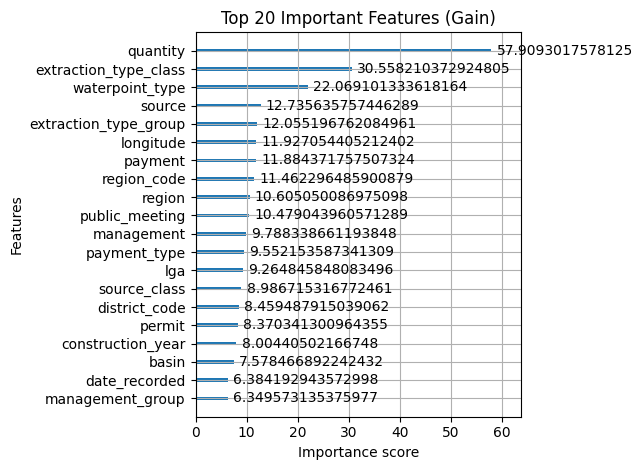

In [73]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Important Features (Gain)")
plt.tight_layout()
plt.show()

In [76]:
# Load and preprocess test set
test_data = pd.read_csv("../data/raw/Test_Set_Values.csv")

X_test = test_data.drop(columns=['recorded_by'],axis=1)
X_test = X_test.fillna('missing')

# Convert all object and bool columns to strings before encoding
for col in X_test.select_dtypes(include=['object', 'bool']).columns:
    X_test[col] = X_test[col].astype(str)
    X_test[col] = LabelEncoder().fit_transform(X_test[col])

# Prepare submission
submission = pd.read_csv("../data/raw/Submission_format.csv")
#submission["status_group"] = test_predictions
y_pred_test = xgb_model.predict(X_test)
submission["status_group"] = y_pred_test.flatten()
submission.to_csv("submission_xgb.csv", index=False)

In [77]:
importance_dict = xgb_model.get_booster().get_score(importance_type='gain')
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

for feature, score in sorted_importance[:10]:
    print(f"{feature}: {score}")


quantity: 57.9093017578125
extraction_type_class: 30.558210372924805
waterpoint_type: 22.069101333618164
source: 12.735635757446289
extraction_type_group: 12.055196762084961
longitude: 11.927054405212402
payment: 11.884371757507324
region_code: 11.462296485900879
region: 10.605050086975098
public_meeting: 10.479043960571289


In [80]:
import shap
import matplotlib.pyplot as plt

# Sample data for SHAP explanation
X_sample = X_train if len(X_train) < 1000 else X_train.sample(1000, random_state=42)

# Use new SHAP explainer
explainer = shap.Explainer(modelc, X_sample)

# Compute SHAP values (Shape: [samples, features, classes])
shap_values = explainer(X_sample)

# Confirm shape
print("SHAP values shape:", shap_values.values.shape)  # Should be [1000, num_features, 3]

# Class names (you can customize)
class_names = ['Class 0 - Non Functional', 'Class 1 - Needs Repair', 'Class 2 - Functional']

# Plot beeswarm for each class
for i in range(shap_values.values.shape[2]):
    print(f"\nGenerating SHAP summary for: {class_names[i]}")
    shap.summary_plot(shap_values.values[:, :, i], X_sample, show=True)


: 